# Aplicaremos Analisis de Componentes Principales 
## (PCA por sus siglas en ingles)

Cargamos las librerias que usaremos

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.sql.functions import expr, col

Volvemos a crear una sesion con Spark y aumentar la memoria para no tener problemas luego

In [2]:
spark = SparkSession.builder \
    .appName("ZooSpec") \
    .config("spark.driver.memory", "6g") \
    .getOrCreate()

Explicacions del DataFrame que usaremos [T_F_DR14_ZooSpec_10000.csv](https://public.pic.es/s/6p3loHQQvOXPm00/download) (~95 Mb en zip, ~600 Mb una vez descomprimido):

Las imágenes de galaxias tomadas por un telescopio son almacenadas en la carpeta 64x64 como imágenes JPEG de 64x64 píxeles.
Se convertieron cada una de las imágenes en un vector de $64*64=4096$ posiciones, con los siguientes pasos:
* Convertir la imagen en color en una imagen en blanco y negro. Cada uno de los píxeles de la imagen contiene 3 valores entre 0 y 255 correspondientes a los 3 canales RGB (R=Rojo, G=Verde, B=Azul). Podríamos decir que cada imagen está compuesta por tres matrices 64x64: MR, MG y MB, correspondientes a los canales R, G y B respectivamente. Aplicamos la siguiete fórmula para fusionar las tres matrices en una sola matriz (M) en tonos de gris: $M = 0.2989 * MR + 0.5870 * MG + 0.1140 * MB$.
* Se reorganizo la matriz de 64x64 a un unico vector de 4096 valores.
* Muchos algoritmos funcionan mejor si todas las variables se encuentran dentro del mismo rango de valores, típicamente [-1, 1] o [0, 1], por este motivo se normalizaron los datos dividiendo los valores por 255.
* La variable **Target**:
    * 0 - incierto
    * 1 - elíptica
    * 2 - espiral

Este conjunto de datos tiene los campos:
* **dr7objid​**: identificador del objeto
* **target​**: clase del objeto según la definición anterior
* **F0 a F4095**​: correspondientes a la tupla de 4096 atributos anteriormente descrita

In [3]:
# Leemos los datos del archivo CSV
df_zoo = spark.read.csv("csvs/T_F_DR14_ZooSpec_10000.csv", header=True, inferSchema=True)

# Registramos el DataFrame como tabla SQL
df_zoo.createOrReplaceTempView("ZooSpec")

Veamos cuantas filas y cuantas columnas posee nuestro dataframe

In [4]:
print(f'Nuestro dataframe de spark posee {df_zoo.count()} observaciones o filas y {len(df_zoo.columns)} variables o columnas')

Nuestro dataframe de spark posee 10000 observaciones o filas y 4098 variables o columnas


## Reducción de los datos: Principal Component Analysis (PCA)

Los estructura resultante de los datos no es el ideal para entrenar un algoritmo de clasificación:
* **es muy grande** 3701 filas * 4096 columnas ~ 15M de celdas
* **es poco denso** hay pocas muestras (3701 imágenes) para el número de atributos (4096 píxeles). De intentar aplicar algunos algoritmos de clasificación sobre este conjunto de datos, podríamos incurrir en la [maldición de la dimensión (en inglés)](https://en.wikipedia.org/wiki/Curse_of_dimensionality)

Para solucionar ambos problemas utilizaremos el método PCA para reducir el número de atributos.

Antes de aplicar PCA a los datos, debemos modificar el dataframe creando una columna features que agrupe todas las variables F en un vector

In [5]:
columns = [f'F{i}' for i in range(4096)]

# Combinamos las columnas de características en un solo vector
assembler = VectorAssembler(inputCols=columns, outputCol="features")
df = assembler.transform(df_zoo)
df = df.drop(*columns)

In [6]:
df.columns

['dr7objid', 'target', 'features']

### Filtrado de imágenes no clasificadas

Para el entrenamiento no nos hacen falta todos los datos, nos basta con los datos de aquellas imágenes que se han clasificado satisfactoriamente. Así pues, vamos a descartar aquellas imágenes cuyo campo `target` tiene valor `0`.

In [7]:
# Vemos cuántas imágenes hay de cada tipo
# 0 = incierto
# 1 = elíptica
# 2 = espiral
df.groupBy('target').count().show()

+------+-----+
|target|count|
+------+-----+
|     1| 1291|
|     2| 2410|
|     0| 6299|
+------+-----+



In [8]:
# Construímos un nuevo DataFrame solamente con las imágenes clasificadas
labeled_df = df.filter(df['target'] != 0)

In [9]:
# Vemos que el número de imágenes seleccionadas es coherente con la query anterior
labeled_df.count()

3701

In [10]:
# Construímos otro DataFrame solamente con las imágenes no clasificadas
unlabeled_df = df.filter(df['target'] == 0)

In [11]:
unlabeled_df.count()

6299

Ahora que tenemos un vector con todos los valores F para cada observacion, usaremos dos metodos graficos para determinar cuantos autovectores usaremos para nuestro modelo PCA.
Lamentablemente, en general (y en spark especificamente) el metodo de PCA es muy aleatorio de una ejecucion a otra, por lo que decidi crear una funcion que tome todos k numero de vectores de pca, y se detenga al alcanzar una varianza explicada acumulada del 95%, y ese será el numero de componentes que utilizaremos; si ese objetivo no es alcanzado, se propondra incrementar k para intentar de nuevo

In [12]:
def aplicar_pca(data, k=100, target_variance=0.95, grafica=True):
    # Aplica PCA para obtener los componentes
    pca = PCA(k=k, inputCol="features", outputCol="pca_features")
    pca_model = pca.fit(data)
    
    # Calcula la varianza explicada acumulada
    variance_explained = pca_model.explainedVariance.toArray()
    cumulative_variance = np.cumsum(variance_explained)
    
    try:
        # Encuentra el número de componentes que alcanza al menos el target de varianza
        num_components = np.argmax(cumulative_variance >= target_variance) + 1
        
        if grafica:
            # Traza la curva de la varianza explicada acumulada
            plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
            plt.xlabel('Número de Componentes')
            plt.ylabel('Varianza Explicada Acumulada')
            plt.title('Método del Codo: Varianza Explicada Acumulada')
            plt.axvline(x=num_components, color='r', linestyle='--', label=f'{num_components} componentes')
            plt.legend()
            plt.show()

        print(f'Número de componentes para alcanzar {target_variance*100:.2f}% de varianza explicada: {num_components}')

        return pca_model.transform(data)
    
    except Exception:
        print("No se alcanzó la varianza objetivo, pruebe aumentar el numero de componentes 'k'")


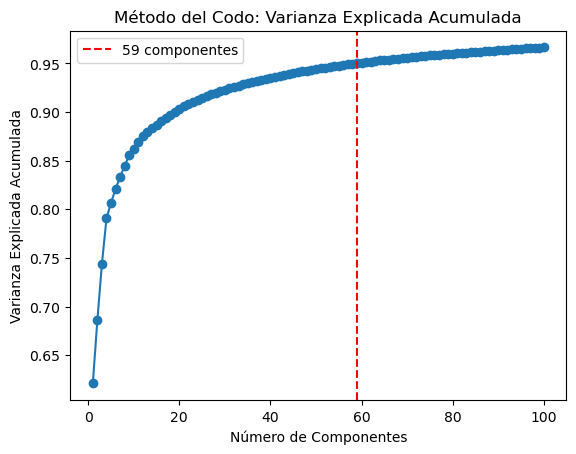

Número de componentes para alcanzar 95.00% de varianza explicada: 59


In [15]:
labeled_df_pca = aplicar_pca(labeled_df)

In [16]:
# mostramos el nuevo dataframe
labeled_df_pca.show()

+------------------+------+--------------------+--------------------+
|          dr7objid|target|            features|        pca_features|
+------------------+------+--------------------+--------------------+
|587738947743055899|     2|[0.084831372549,0...|[-26.015051598168...|
|587722982829850800|     2|[0.0162,0.0162,0....|[-3.9578134453189...|
|587732771049111588|     1|[0.0264705882353,...|[-14.119484129565...|
|587741722822180915|     1|[0.0129803921569,...|[-5.1520509599407...|
|587742568935587892|     2|[0.0474666666667,...|[-10.890650799236...|
|588017606293848123|     1|[0.0316509803922,...|[-4.8107026812432...|
|587736920508399689|     2|[0.0438470588235,...|[-14.220232018174...|
|587741600964411477|     2|[0.0229137254902,...|[-13.605746147215...|
|587733399170515042|     2|[0.00230196078431...|[-3.5374072458329...|
|588010360685592719|     2|[0.0158588235294,...|[-4.3049557996251...|
|587734863221555344|     1|[0.0394078431373,...|[-4.1211074624340...|
|587738196123975836|

Eliminamos la columna features que ya no utilizaremos

In [17]:
labeled_df_pca = labeled_df_pca.drop('features')
labeled_df_pca.columns

['dr7objid', 'target', 'pca_features']

# Apliquemos Machine Learning con Spark

Para poder aplicar el modelo de regressión logística, el campo que contiene la clase, debe ser de tipo `double` (número real), mientras que ahora lo tenemos de tipo `long` (número entero). Así que lo reformateamos. De paso mapeamos el valor del target a {0, 1}
* $elíptica: 1 => 0$
* $espiral: 2 => 1$

In [18]:
df = labeled_df_pca.withColumn('label', (labeled_df_pca['target'] - 1).astype('double'))['dr7objid', 'pca_features', 'label']

## Modelo de Regresión Logística

Aplicaremos un algoritmo de regresión logística para la clasificación de la imágenes de galaxias.

### Partición Test - Train

Dividiremos nuestro set de datos en dos subsets:
* ``df_train``: para el entrenamiento del modelo (Train) con un 80% de los datos
* ``df_test``: para la validación (Test) con un 20% de los datos

In [19]:
df_train, df_test = df.randomSplit([0.8, 0.2], seed=1)

Entrenamos nuestro Modelo Logístico

In [20]:
lgr = LogisticRegression(maxIter=100,
                         featuresCol="pca_features",
                         regParam=0.005)
                        
model = lgr.fit(df_train)

Aqui una lista con la explicacion de los principales parametros que podriamos personalizar:

* ``maxIter``: El número máximo de iteraciones para el algoritmo de optimización. Controla cuántas veces se itera para encontrar los coeficientes óptimos.
* ``regParam``: Parámetro de regularización para evitar el sobreajuste. Un valor mayor implica una regularización más fuerte.
* ``threshold``: Umbral para la predicción de clase binaria.
* ``standardization``: Si debes estandarizar las características antes de ajustar el modelo.
*  ``tol``: se utiliza para controlar cuán pequeño debe ser el cambio en la función de pérdida entre iteraciones consecutivas para que el algoritmo considere que ha alcanzado la convergencia y termine el entrenamiento.

Aqui los parametros por defecto:
``` python
LogisticRegression(featuresCol="features", labelCol="label", predictionCol="prediction", maxIter=100, regParam=0.0, elasticNetParam=0.0, tol=1e-6, fitIntercept=True, threshold=0.5, thresholds=None, probabilityCol="probability", rawPredictionCol="rawPrediction", standardization=True, weightCol=None, aggregationDepth=2, family="auto", lowerBoundsOnCoefficients=None, upperBoundsOnCoefficients=None, lowerBoundsOnIntercepts=None, upperBoundsOnIntercepts=None, maxBlockSizeInMB=0.0)
```

Aplicamos el modelo a nuestros datos para predecir la forma de la galaxia

In [21]:
pred_df = model.transform(df_test)

In [22]:
pred_df.show()

+------------------+--------------------+-----+--------------------+--------------------+----------+
|          dr7objid|        pca_features|label|       rawPrediction|         probability|prediction|
+------------------+--------------------+-----+--------------------+--------------------+----------+
|587722984424669303|[-3.7401839330768...|  0.0|[-0.1446072497572...|[0.46391105442056...|       1.0|
|587725816405753868|[-4.4898010800235...|  1.0|[1.39568385781474...|[0.80149808857558...|       0.0|
|587725816950030507|[-3.1886789098592...|  0.0|[1.09209771483619...|[0.74877652913566...|       0.0|
|587725818026786906|[-4.3776571502360...|  0.0|[1.57795456454373...|[0.82891463934485...|       0.0|
|587726031711371365|[-3.4194130467273...|  1.0|[-2.3535675580446...|[0.08678262136332...|       1.0|
|587728669342564757|[-11.221781775147...|  1.0|[-0.2766341744943...|[0.43127914544912...|       1.0|
|587728881410638072|[-5.1264397538016...|  1.0|[-1.5219604628994...|[0.17917301267254...|  

Creamos una funcion para medir la eficiencia de nuestro modelo

In [23]:
def metricas(pred_df):
    # Crea una columna que representa la predicción como int
    pred_df = pred_df.withColumn("prediction_int", expr("CAST(prediction AS INT)"))

    # Calcula la matriz de confusión
    confusion_matrix = pred_df.crosstab("label", "prediction_int").sort("label_prediction_int")

    # Métricas específicas
    true_positive = confusion_matrix.filter("label_prediction_int = 1").select("1").collect()[0][0]
    false_positive = confusion_matrix.filter("label_prediction_int = 1").select("0").collect()[0][0]
    true_negative = confusion_matrix.filter("label_prediction_int = 0").select("0").collect()[0][0]
    false_negative = confusion_matrix.filter("label_prediction_int = 0").select("1").collect()[0][0]

    recall = true_positive / (true_positive + false_negative)
    specificity = true_negative / (true_negative + false_positive)
    precision = true_positive / (true_positive + false_positive)
    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Imprime las métricas
    print("Métricas de Evaluación:")
    print(f"Recall / Sensitivity: {recall:.3f}")
    print(f"Specificity: {specificity:.3f}")
    print(f"Precisión: {precision:.3f}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1-score: {f1_score:.3f}")

    print("Matriz de Confusión:")
    confusion_matrix.show()

In [24]:
metricas(pred_df)

Métricas de Evaluación:
Recall / Sensitivity: 0.857
Specificity: 0.764
Precisión: 0.862
Accuracy: 0.823
F1-score: 0.859
Matriz de Confusión:
+--------------------+---+---+
|label_prediction_int|  0|  1|
+--------------------+---+---+
|                 0.0|204| 66|
|                 1.0| 63|394|
+--------------------+---+---+



Como vemos, aunque la prediccion alcanza al 82% de accuracy, aun podriamos intentar mejor esto, es por esto que utilizaremos otro tipo de modelo. En este caso voy a utilizar un algoritmo basado en grandiente, el ``gradient boosting``.

# Modelo GBTClassifier

``GBTClassifier`` se basa en la idea de construir árboles secuenciales, donde cada árbol intenta corregir los errores del anterior. Esta técnica es especialmente efectiva para problemas de clasificación.

Ahora creamos clasificador boosting y lo entrenamos.

In [25]:
mlp = GBTClassifier(labelCol="label",
                    featuresCol="pca_features", 
                    maxIter=100, 
                    seed=1)

Que parametros posee el modelo:

``` python
GBTClassifier(featuresCol: str = 'features', labelCol: str = 'label', predictionCol: str = 'prediction', maxDepth: int = 5, maxBins: int = 32, minInstancesPerNode: int = 1, minInfoGain: float = 0.0, maxMemoryInMB: int = 256, cacheNodeIds: bool = False, checkpointInterval: int = 10, lossType: str = 'logistic', maxIter: int = 20, stepSize: float = 0.1, seed: Optional[int] = None, subsamplingRate: float = 1.0, impurity: str = 'variance', featureSubsetStrategy: str = 'all', validationTol: float = 0.01, validationIndicatorCol: Optional[str] = None, leafCol: str = '', minWeightFractionPerNode: float = 0.0, weightCol: Optional[str] = None)
```

Parametros que podriamos modificar:

* ``maxDepth``: La profundidad máxima de los árboles individuales. Controla la complejidad de los árboles y, por lo tanto, la capacidad de ajuste del modelo. Un valor más alto permitirá que los árboles sean más profundos, lo que puede llevar a un sobreajuste si no se controla.

* ``maxBins``: El número máximo de contenedores en los que se dividen las características continuas. Un valor más alto permite capturar relaciones más complejas en los datos, pero también puede aumentar el costo computacional.

* ``maxIter``: El número máximo de iteraciones (número de árboles) en el proceso de impulso. Cuantas más iteraciones, más complejo será el modelo, pero existe el riesgo de sobreajuste.

* ``stepSize``: El tamaño del paso en cada iteración al buscar la dirección óptima para mejorar el modelo. Un valor más grande puede acelerar la convergencia, pero también puede hacer que se salte la solución óptima.

* ``subsamplingRate``: La tasa de submuestreo que se utiliza para entrenar cada árbol. Por ejemplo, si es 0.8, se utilizará el 80% de los datos para entrenar cada árbol individualmente. Puede acelerar el entrenamiento pero también puede llevar a una menor generalización.

* ``lossType``: El tipo de función de pérdida a utilizar. Puede ser "logistic" para clasificación binaria y "squared" para regresión. La pérdida logística es comúnmente utilizada en problemas de clasificación.

In [26]:
mlp_model = mlp.fit(df_train)

Validemos el modelo, primero predecimos los valores

In [27]:
pred_df = mlp_model.transform(df_test)

In [28]:
# Llamamos a la función pasando el DataFrame de predicciones
metricas(pred_df)

Métricas de Evaluación:
Recall / Sensitivity: 0.934
Specificity: 0.930
Precisión: 0.961
Accuracy: 0.933
F1-score: 0.947
Matriz de Confusión:
+--------------------+---+---+
|label_prediction_int|  0|  1|
+--------------------+---+---+
|                 0.0|239| 31|
|                 1.0| 18|439|
+--------------------+---+---+



Obtuvimos un Accuracy del 93%, bastante mejor que el obtenido con la regresion logistica

## Clasificando las galaxias que quedan sin clasificar

Tomaremos las observaciones guardadas en unlabeled_df y convertiremos la columna features con el algortimo de pca utilizado anteriormente y aplicamos todos los cambios que ya hicimos con las observaciones etiquetadas anteriormente

In [35]:
pca = PCA(k=59, inputCol="features", outputCol="pca_features")
model_pca = pca.fit(unlabeled_df)
unlabeled_df_pca = model_pca.transform(unlabeled_df)

In [36]:
unlabeled_df_pca = unlabeled_df_pca.drop('features')

In [37]:
df_unlab = unlabeled_df_pca.withColumn('label', (unlabeled_df_pca['target'] - 1).astype('double'))['dr7objid', 'pca_features', 'label']

Finalmente clasificamos los datos sin etiquetar

In [38]:
unlabeled_clasificado = mlp_model.transform(df_unlab)

In [54]:
unlabeled_clasificado.columns

['dr7objid',
 'pca_features',
 'label',
 'rawPrediction',
 'probability',
 'prediction']

Pasamos los datos a pandas y guardamos en csv

In [ ]:
df = unlabeled_clasificado.select("dr7objid", "prediction").toPandas()
df
df.to_csv("etiquetados.csv", index=False)

In [ ]:
# Detenemos la instancia de Spark
spark.stop()